# Cross Validation

The aim of this notebook is to train one or more small-scale models on data from the **Zeeguu** game. We hope to improve the performance obtained with the zero-shot model ([notebooks/topic_classification/b_ZeroShot.ipynb](b_ZeroShot.ipynb)).

In [1]:
# -------------------------------- PARAMETERS -------------------------------- #
BATCH_SIZE = 8

In [ ]:
# ---------------------------- PREPARING NOTEBOOK ---------------------------- #
# Autoreload
%load_ext autoreload
%autoreload 2

# Random seed
import numpy as np
np.random.seed(42)

# External modules
import os
from IPython.display import display, Markdown, Latex, clear_output
from tqdm import notebook as tqdm

# Set global log level
import logging
logging.basicConfig(level=logging.INFO)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Define PWD as the current git repository
import git
repo = git.Repo('.', search_parent_directories=True)
pwd = repo.working_dir
os.chdir(pwd)

# Connect WandB
import wandb
wandb.login()
wandb.init(mode="disabled")

In [3]:
# ------------------------------- LOAD DATASETS ------------------------------ #
import pandas as pd
from huggingface_hub import snapshot_download


def load_data(sample: int = None, pwd: str = "."):
    # Create fodler
    dataset_path = os.path.join(
        pwd,
        "data",
        "processed",
        "topic_classification",
        "CrossValidation",
    )
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    # Download CSVs
    snapshot_download(
        repo_id="OloriBern/FLDE",
        allow_patterns=["topic_classification/*.csv"],
        local_dir=dataset_path,
        revision="main",
        repo_type="dataset",
    )

    dataset_path = os.path.join(dataset_path, "topic_classification")

    # Load datasets
    train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
    test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"))
    full_df = pd.concat([train_df, test_df])

    # Sample
    train_df = train_df.sample(sample) if sample else train_df
    test_df = test_df.sample(sample) if sample else test_df
    full_df = full_df.sample(sample) if sample else full_df

    return train_df, test_df, full_df


train_dataset, test_df, full_df = load_data(100, pwd)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# ------------------------------ CREATE DATASET ------------------------------ #
from datasets import Dataset


def create_dataset(df: pd.DataFrame):
    from datasets import Dataset

    dataset = Dataset.from_pandas(df)
    dataset = dataset.rename_column("topic", "label")

    return dataset


train_dataset = create_dataset(train_dataset)
test_dataset = create_dataset(test_df)

## Flaubert

First, we will train the same model as the one used for the zero-shot, but this time on Zeeguu data. We will use the Flaubert-base-cased model.

In [5]:
# -------------------------------- LOAD MODEL -------------------------------- #
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


def load_model(model_name: str, num_labels: int = 10):
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

    # Move model to GPU
    if torch.cuda.is_available():
        model.to("cuda")

    return tokenizer, model


tokenizer, model = load_model("flaubert/flaubert_base_cased", full_df.topic.nunique())

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# ----------------------------- TOKENIZE DATASET ----------------------------- #
from sklearn import preprocessing
from datasets import Dataset
from transformers import AutoTokenizer


def tokenize_dataset(dataset: Dataset, tokenizer: AutoTokenizer):
    # Tokenize
    def tokenize(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True)

    # Encode labels
    label_encoder = preprocessing.LabelEncoder()

    # Apply functions
    dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))
    dataset = dataset.map(
        lambda examples: {"label": label_encoder.fit_transform(examples["label"])},
        batched=True,
    )
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    return dataset, label_encoder


train_dataset, label_encoder = tokenize_dataset(train_dataset, tokenizer)
test_dataset, _ = tokenize_dataset(test_dataset, tokenizer)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [7]:
# ------------------------------ CREATE TRAINER ------------------------------ #
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datetime import datetime


def create_trainer(
    model,
    train_inputs,
    test_inputs,
    epochs: int = 1,
    batch_size: int = 8,
    pwd: str = ".",
):
    # Create output directory
    output_dir = os.path.join(pwd, "scratch", "topic_classification", "CrossValidation")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Configure WandB
    os.environ["WANDB_PROJECT"] = "flaubert_topic_classification"

    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=output_dir,
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        run_name=f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
        report_to="wandb",
        load_best_model_at_end=True,
    )

    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=3
    )  # Définir le nombre de validation steps avant l'arrêt

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_inputs,
        eval_dataset=test_inputs,
        callbacks=[early_stopping],
    )

    return trainer


trainer = create_trainer(
    model, train_dataset, test_dataset, epochs=1, batch_size=BATCH_SIZE, pwd=pwd
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.454400,2.523170


TrainOutput(global_step=13, training_loss=2.4579255397503195, metrics={'train_runtime': 11.7213, 'train_samples_per_second': 8.532, 'train_steps_per_second': 1.109, 'total_flos': 26131801804800.0, 'train_loss': 2.4579255397503195, 'epoch': 1.0})

In [8]:
# --------------------------- RAY TRAINING FUNCTION -------------------------- #
import ray.train.huggingface.transformers
import dill


def train_model(config):
    # Fix partial import bug
    import ray.train.huggingface
    import ray.train.huggingface.transformers

    # Load arguments
    model_name = config["model_name"]
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    use_ray = config["use_ray"]
    sample = config["sample"]
    pwd = config["pwd"]

    # Load data
    train_dataset, test_df, full_dataset = load_data(sample, pwd)

    # Create dataset
    train_dataset = create_dataset(train_dataset)
    test_dataset = create_dataset(test_df)

    # Load model
    tokenizer, model = load_model(model_name, full_dataset.topic.nunique())

    # Tokenize dataset
    train_dataset, train_label_encoder = tokenize_dataset(train_dataset, tokenizer)
    test_dataset, test_label_encoder = tokenize_dataset(test_dataset, tokenizer)

    # Create trainer
    trainer = create_trainer(
        model,
        train_dataset,
        test_dataset,
        epochs=epochs,
        batch_size=batch_size,
        pwd=pwd,
    )

    if use_ray:
        # Add ray tune callback
        callback = ray.train.huggingface.transformers.RayTrainReportCallback()
        trainer.add_callback(callback)
        trainer = ray.train.huggingface.transformers.prepare_trainer(trainer)

    # Start Training
    trainer.train()

    # Pickle result
    if use_ray:
        with open(os.path.join(pwd, "flaubert_trained.pkl"), "wb") as f:
            dill.dump((model, test_label_encoder), f)

    return model, train_label_encoder, test_label_encoder


model, train_label_encoder, test_label_encoder = train_model(
    {
        "model_name": "flaubert/flaubert_base_cased",
        "epochs": 1,
        "batch_size": BATCH_SIZE,
        "use_ray": False,
        "sample": 100,
        "pwd": pwd,
    }
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,2.524400,2.540662


In [9]:
# ----------------------------- SLURMRAY TRAINING ---------------------------- #
from ray.train import ScalingConfig, CheckpointConfig, RunConfig
from ray.train.torch import TorchTrainer
from slurmray.RayLauncher import RayLauncher


def slurmray_function():
    # Define config
    config = {
        "model_name": "flaubert/flaubert_base_cased",
        "epochs": 20,
        "batch_size": 32,
        "use_ray": True,
        "sample": None,
        "pwd": "/scratch/hjamet",
    }

    # Create ray launcher
    ray_trainer = TorchTrainer(
        train_model,
        scaling_config=ScalingConfig(num_workers=1, use_gpu=True),
        run_config=RunConfig(
            checkpoint_config=CheckpointConfig(
                num_to_keep=1
            ),  # No more needed with the new storage path
            storage_path="/scratch/hjamet",
        ),
        train_loop_config=config,
    )

    # Start training
    result = ray_trainer.fit()

    # Get the result
    with open(os.path.join("/scratch/hjamet", "flaubert_trained.pkl"), "rb") as f:
        model, test_label_encoder = dill.load(f)

    return model, test_label_encoder


# Create ray launcher
launcher = RayLauncher(
    project_name="flaubert-topic-classification",
    func=slurmray_function,
    args={},
    modules=[],
    node_nbr=1,
    use_gpu=True,
    memory=64,
    max_running_time=60,
    server_run=True,
    server_ssh="curnagl.dcsr.unil.ch",
    server_username="hjamet",
)

result = launcher()

Serializing function and arguments...
Connecting to the cluster...


INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_8.0)
INFO:paramiko.transport:Authentication (password) successful!
INFO:paramiko.transport.sftp:[chan 0] Opened sftp connection (server version 3)


Writing slurmray server script...
Running server...
Installing slurmray server
Looking in indexes: https://download.pytorch.org/whl/cu121
Writing python script...
Writing slurm script...
No serialization done.
Cluster detected, running on cluster...
Canceling old jobs...
Start to submit job!
Job submitted! Script file is at: </users/hjamet/slurmray-server/.slogs/server/sbatch.sh>. Log file is at: </users/hjamet/slurmray-server/.slogs/server/server_2901-23h56.log>
Start to monitor the queue... You can check the queue at: </users/hjamet/slurmray-server/.slogs/server/server_2901-23h56_queue.log>
Submitted batch job 37800402
IP Head: 10.203.101.87:6379
STARTING HEAD at dnagpu007
2024-01-29 23:56:10,712	INFO usage_lib.py:449 -- Usage stats collection is enabled by default without user confirmation because this terminal is detected to be non-interactive. To disable this, add `--disable-usage-stats` to the command that starts the cluster, or run the following command: `ray disable-usage-stats

In [10]:
# -------------------------------- SAVE RESULT ------------------------------- #
model, test_label_encoder = result

model.save_pretrained(
    os.path.join(
        pwd, "scratch", "topic_classification", "CrossValidation", "flaubert_fine_tuned"
    )
)
with open(
    os.path.join(
        pwd,
        "scratch",
        "topic_classification",
        "CrossValidation",
        "flaubert_fine_tuned_label_encoder.pkl",
    ),
    "wb",
) as f:
    dill.dump(test_label_encoder, f)

In [11]:
# --------------------------- COMPUTING PREDICTIONS -------------------------- #
from torch.utils.data import DataLoader
from datasets import Dataset

# Load model, tokenizer and label encoder
model = AutoModelForSequenceClassification.from_pretrained(
    os.path.join(
        pwd, "scratch", "topic_classification", "CrossValidation", "flaubert_fine_tuned"
    )
).cuda()
tokenizer = AutoTokenizer.from_pretrained("flaubert/flaubert_base_cased")
label_encoder = dill.load(
    open(
        os.path.join(
            pwd,
            "scratch",
            "topic_classification",
            "CrossValidation",
            "flaubert_fine_tuned_label_encoder.pkl",
        ),
        "rb",
    )
)

# Load test dataset
_, test_df, _ = load_data(None, pwd)
test_dataset = create_dataset(test_df)
test_dataset, _ = tokenize_dataset(test_dataset, tokenizer)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Compute predictions
predictions = {"labels": [], "scores": []}
for batch in tqdm.tqdm(test_dataloader):
    with torch.no_grad():
        model.eval()
        outputs = model(
            input_ids=batch["input_ids"].cuda(),
            attention_mask=batch["attention_mask"].cuda(),
            labels=batch["label"].cuda(),
        )
        labels = label_encoder.classes_
        scores = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        # Sort labels by score
        labels = np.array(labels)[np.argsort(-scores, axis=1)]
        scores = -np.sort(-scores, axis=1)
        predictions["labels"].extend(labels)
        predictions["scores"].extend(scores)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [15]:
# Create results dataframe
result = pd.DataFrame(predictions)
result["label"] = label_encoder.inverse_transform(test_dataset["label"])

# Save results
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "FlaubertFineTuned",
    "flaubert_fine_tuned_predictions.csv",
)
## Create folder if it does not exist
os.makedirs(os.path.dirname(path), exist_ok=True)
result.to_csv(path, index=False)

result

,labels,scores,label
0,"[Sport, Culture, Travel, Business, Science, Te...","[0.890728, 0.04299058, 0.016657947, 0.01547819...",Sport
1,"[Politics, Culture, Business, Sport, Science, ...","[0.9620973, 0.010566838, 0.010536679, 0.004525...",Politics
2,"[Music, Culture, Health, Travel, Science, Busi...","[0.94707555, 0.04526277, 0.002522819, 0.001250...",Music
3,"[Sport, Business, World, Health, Science, Trav...","[0.8819398, 0.040212538, 0.027070556, 0.018365...",Sport
4,"[World, Culture, Travel, Science, Technology, ...","[0.62565833, 0.17055269, 0.11382687, 0.0288433...",World
...,...,...,...
354,"[Culture, Music, Technology, Travel, Politics,...","[0.528092, 0.15919222, 0.06559812, 0.060517345...",Sport
355,"[Culture, World, Travel, Science, Music, Healt...","[0.9147009, 0.028320983, 0.022130083, 0.014345...",Culture
356,"[Music, Culture, Health, Business, Travel, Spo...","[0.9850199, 0.010939114, 0.00094614265, 0.0006...",Music
357,"[Health, Science, Business, Sport, Technology,...","[0.9208803, 0.05005789, 0.014498813, 0.0042143...",Sport


,accuracy@1,accuracy@3,accuracy@5
Science,0.454545,0.939394,1.000000
Politics,0.500000,0.750000,0.812500
Business,0.625000,0.906250,0.937500
Health,0.636364,0.878788,0.878788
Culture,0.757576,0.969697,1.000000
World,0.812500,0.968750,0.968750
Travel,0.812500,0.968750,1.000000
Sport,0.818182,0.848485,0.939394
Technology,0.878788,0.939394,0.939394
Music,0.939394,1.000000,1.000000


,accuracy,precision,recall,f1
FlaubertFineTuned,0.743733,0.743733,0.743733,0.743733


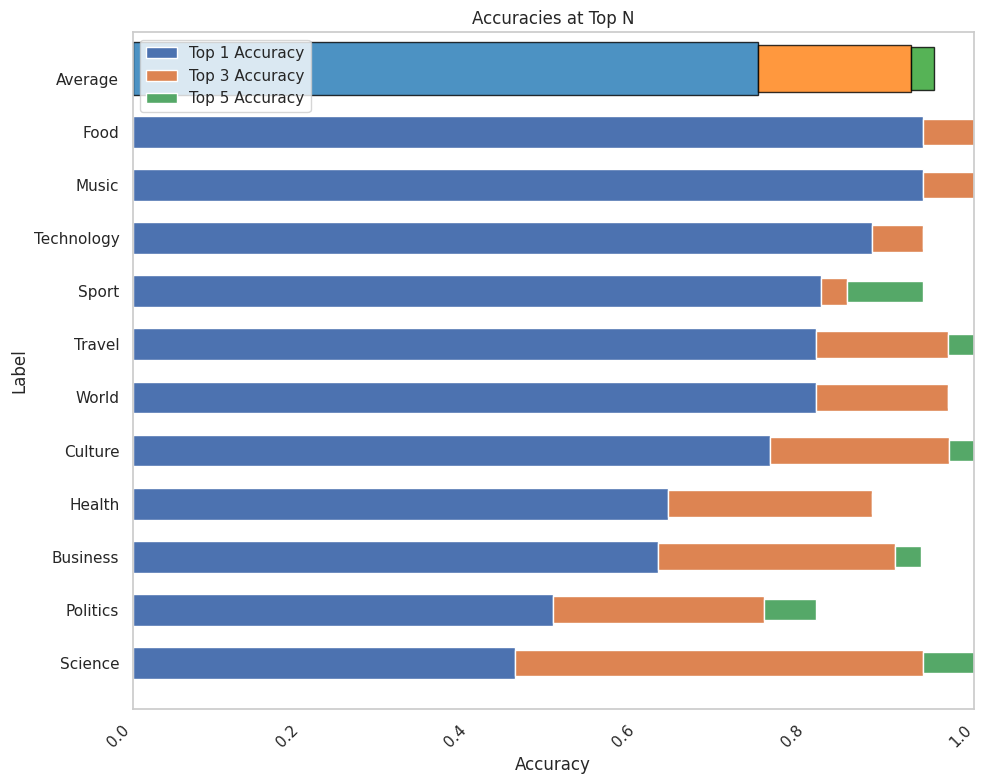

In [17]:
import pandas as pd


def is_in_top_n(label: str, n: int = 1):
    return result[result["label"] == label]["labels"].apply(lambda x: label in x[:n])


metrics = {}
for label in result["label"].unique():
    metrics[label] = {
        "accuracy@1": is_in_top_n(label, 1).mean(),
        "accuracy@3": is_in_top_n(label, 3).mean(),
        "accuracy@5": is_in_top_n(label, 5).mean(),
    }
metrics["Average"] = {
    "accuracy@1": result.apply(lambda x: x["label"] in x["labels"][:1], axis=1).mean(),
    "accuracy@3": result.apply(lambda x: x["label"] in x["labels"][:3], axis=1).mean(),
    "accuracy@5": result.apply(lambda x: x["label"] in x["labels"][:5], axis=1).mean(),
}

metrics = pd.DataFrame(metrics).T
metrics = metrics.sort_values("accuracy@1", ascending=True)

# Move Average row to the top
metrics = pd.concat([metrics.drop("Average"), metrics.loc[["Average"]]])

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "FlaubertFineTuned",
    "flaubert_fine_tuned_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
metrics.to_csv(path)

display(metrics)

# Calculate precision, recall and f1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0]).tolist(),
    average="micro",
)
recall = recall_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0]).tolist(),
    average="micro",
)
f1 = f1_score(
    result["label"].tolist(),
    result["labels"].apply(lambda x: x[0]).tolist(),
    average="micro",
)
classification_metrics = pd.DataFrame(
    {
        "accuracy": [metrics.loc["Average", "accuracy@1"]],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1],
    },
    index=["FlaubertFineTuned"],
)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "topic_classification",
    "FlaubertFineTuned",
    "flaubert_fine_tuned_classification_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
classification_metrics.to_csv(path)

display(classification_metrics)

import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que le DataFrame 'metrics' est déjà créé et trié par 'accuracy@1'
# metrics.sort_values("accuracy@1", ascending=False)

# Réinitialiser l'index pour pouvoir utiliser la colonne des labels dans le graphique
metrics.reset_index(inplace=True)
metrics.rename(columns={"index": "Label"}, inplace=True)

# Nous utilisons seaborn pour un style de graphique amélioré
sns.set_theme(style="whitegrid")

# La taille du graphique peut être ajustée pour mieux s'adapter à vos données
plt.figure(figsize=(10, 8))

# Création d'un graphique à barres empilées
# bottom paramètre spécifie où la barre commence, donc nous empilons en additionnant la précision précédente
plt.barh(metrics["Label"], metrics["accuracy@1"], label="Top 1 Accuracy", height=0.6)
plt.barh(
    metrics["Label"],
    metrics["accuracy@3"] - metrics["accuracy@1"],
    label="Top 3 Accuracy",
    height=0.5,
    left=metrics["accuracy@1"],
)
plt.barh(
    metrics["Label"],
    metrics["accuracy@5"] - metrics["accuracy@3"],
    label="Top 5 Accuracy",
    height=0.4,
    left=metrics["accuracy@3"],
)

# Titre du graphique et étiquettes des axes
plt.title("Accuracies at Top N")
plt.xlabel("Accuracy")
plt.ylabel("Label")

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité si nécessaire
plt.xticks(rotation=45, ha="right")

# Ajout d'une légende
plt.legend()

# Utilisez plt.tight_layout() si vous constatez que les étiquettes sont coupées dans la sortie finale
plt.tight_layout()

# Remove grid
plt.grid(False)

# Give specific color to first bar
plt.gca().get_children()[11].set(
    color="#1f77b4", alpha=0.8, edgecolor="black", height=1
)
plt.gca().get_children()[23].set(
    color="#ff7f0e", alpha=0.8, edgecolor="black", height=0.9
)
plt.gca().get_children()[35].set(
    color="#2ca02c", alpha=0.8, edgecolor="black", height=0.8
)

# Affichage du graphique
plt.show()